5. Factors for higher fuel consumption (FC) and cost analysis:
    * FC vs cargo weight
    * FC vs # passengers
    * FC vs flight speed
    * FC vs taxi time/departure delays
    * FC vs (short/medium/long) haul rates vs flights (FC/Distance)
    * Are on time planes (least delays) have better fuel economy?

In [1]:
# Make fuel prediction
# https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft

In [2]:
import numpy as np 
import pandas as pd
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
from functools import reduce

plt.style.use('seaborn')


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

C:\Users\Jesse\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
data_path = 'C:/Users/Jesse/Desktop/midterm_data/data/'
flights = pd.read_csv(data_path + 'flights.csv', parse_dates=['fl_date'])
fuel = pd.read_csv(data_path+'fuel_comsumption.csv')
passengers = pd.read_csv(data_path + 'passengers.csv')

In [4]:
carrier_codes = fuel.loc[fuel['carrier'].isin(flights['mkt_carrier'].unique()), 
         ['carrier', 'carrier_name']].groupby(['carrier', 'carrier_name']).count().reset_index().set_index('carrier').to_dict()['carrier_name']

In [5]:
# Domestic flights 2019/2018

domestic_flights_fuel2019 = fuel.loc[(fuel['carrier'].isin(flights['mkt_carrier'].unique())) & (fuel['year'] == 2019)]
domestic_flights_fuel2018 = fuel.loc[(fuel['carrier'].isin(flights['mkt_carrier'].unique())) & (fuel['year'] == 2018)]

domestic_flights_fuel2019.shape, domestic_flights_fuel2018.shape

((90, 25), (120, 25))

In [6]:
domestic_flights_fuel2019 = domestic_flights_fuel2019.groupby(['carrier', 'year', 'month'])['sdomt_gallons', 'tdomt_gallons', 'total_gallons'].sum().reset_index()
domestic_flights_fuel2018 = domestic_flights_fuel2018.groupby(['carrier', 'year', 'month'])['sdomt_gallons', 'tdomt_gallons', 'total_gallons'].sum().reset_index()

In [7]:
domestic_passengers2019 = passengers.loc[(passengers['carrier'].isin(flights['mkt_carrier'].unique())) & (passengers['year'] == 2019)]
domestic_passengers2018 = passengers.loc[(passengers['carrier'].isin(flights['mkt_carrier'].unique())) & (passengers['year'] == 2018)]

domestic_passengers2019 = domestic_passengers2019.loc[:, ['passengers', 'freight', 'distance', 'air_time', 'carrier', 'month', 'year']]
domestic_passengers2018 = domestic_passengers2018.loc[:, ['passengers', 'freight', 'distance', 'air_time', 'carrier', 'month', 'year']]

In [8]:
# <1500 short haul
# between 1500 and 3000 Medium Hail
# >3000 long hauls

def get_haul(x):
    if x < 1500:
        return 'short'
    elif x>=1500 and x<3000:
        return 'medium'
    elif x >= 3000:
        return 'long'


domestic_passengers2019['haul'] = domestic_passengers2019['distance'].apply(lambda x: get_haul(x))
domestic_passengers2018['haul'] = domestic_passengers2018['distance'].apply(lambda x: get_haul(x))




In [11]:
# create month column
flights['month'] = flights['fl_date'].dt.month
flights['year'] = flights['fl_date'].dt.year

In [12]:
flights2019 = flights.loc[(flights['fl_date'].dt.year == 2019) & (flights['air_time'].notna()) & (flights['distance'].notna())]
flights2018 = flights.loc[(flights['fl_date'].dt.year == 2018) & (flights['air_time'].notna()) & (flights['distance'].notna())]

In [13]:
flights2019['speed'] = (flights2019['distance']/flights2019['air_time'])*60
flights2018['speed'] = (flights2018['distance']/flights2018['air_time'])*60

In [14]:
flights2019 = flights2019.loc[:, ['month', 'year', 'mkt_carrier', 'speed', 'distance']].rename({'mkt_carrier': 'carrier'}, axis=1)
flights2018 = flights2018.loc[:, ['month', 'year', 'mkt_carrier', 'speed', 'distance']].rename({'mkt_carrier': 'carrier'}, axis=1)

In [16]:
flights2019['haul'] = flights2019['distance'].apply(lambda x: get_haul(x))
flights2018['haul'] = flights2018['distance'].apply(lambda x: get_haul(x))

#### Calculating fuel efficiency

In [140]:
distance_passengers2019=domestic_passengers2019.groupby('carrier')['distance', 'passengers'].sum().reset_index()
fuel_comp2019 = domestic_flights_fuel2019.groupby('carrier')['tdomt_gallons'].sum().reset_index()
df_fuel_efficiency2019 = pd.merge(left=distance_passengers2019, right=fuel_comp2019, on='carrier')
df_fuel_efficiency2019['efficiency'] = df_fuel_efficiency2019['distance']/df_fuel_efficiency2019['tdomt_gallons']
# https://news.flyfrontier.com/frontier-airlines-ranked-first-among-us-carriers-in-fuel-efficiency-by-icct-report/#:~:text=Sept.,on%20Clean%20Transportation%20(ICCT).

df_fuel_efficiency2019.sort_values('efficiency', ascending=False)

,carrier,distance,passengers,tdomt_gallons,efficiency
4,F9,16156396,22823412,1.965238e+08,0.082211
5,G4,11232516,15121937,1.475114e+08,0.076147
8,UA,61111360,116742820,1.326797e+09,0.046059
7,NK,13733814,34535559,3.140678e+08,0.043729
1,AS,18139953,36021420,5.410686e+08,0.033526
3,DL,47088781,162825498,1.669109e+09,0.028212
0,AA,39438932,156153025,1.706431e+09,0.023112
9,WN,33372606,166799208,1.532522e+09,0.021776
6,HA,2999581,11535119,1.384593e+08,0.021664
2,B6,11130244,42836473,5.212667e+08,0.021352


In [141]:
distance_passengers2018 = domestic_passengers2018.groupby('carrier')['distance', 'passengers'].sum().reset_index()
fuel_comp2018 = domestic_flights_fuel2018.groupby('carrier')['tdomt_gallons'].sum().reset_index()
df_fuel_efficiency2018 = pd.merge(left=distance_passengers2018, right=fuel_comp2018, on='carrier')
df_fuel_efficiency2018['efficiency'] = df_fuel_efficiency2018['distance']/df_fuel_efficiency2018['tdomt_gallons']

df_fuel_efficiency2018.sort_values('efficiency', ascending=False)

,carrier,distance,passengers,tdomt_gallons,efficiency
5,G4,11880708,13847451,1.900442e+08,0.062515
4,F9,12266369,19810472,2.358402e+08,0.052011
8,UA,55533974,113668262,1.703132e+09,0.032607
7,NK,8953779,29273040,3.726584e+08,0.024027
3,DL,48481284,152333597,2.124664e+09,0.022818
1,AS,16209275,34067799,7.128177e+08,0.022740
9,WN,35501625,167943305,2.071543e+09,0.017138
0,AA,37259473,148593504,2.213370e+09,0.016834
6,HA,2992813,11637528,1.858207e+08,0.016106
2,B6,10352394,42254045,6.831706e+08,0.015153


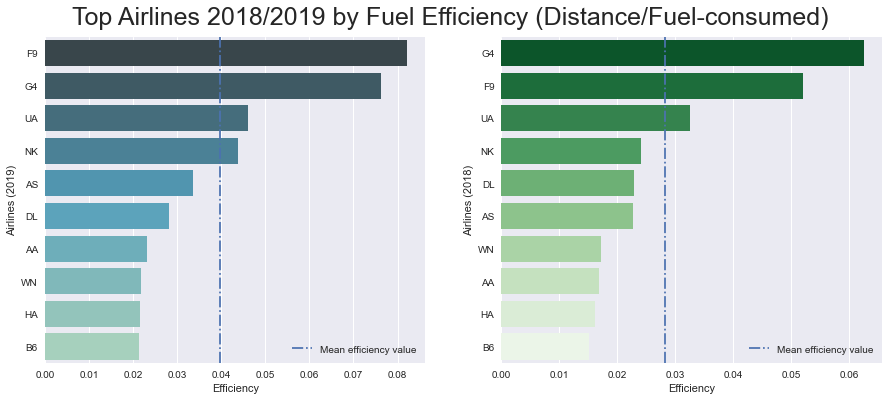

In [142]:
f, axes = plt.subplots(1, 2, figsize=(15,6))

sns.barplot(x='efficiency', y='carrier', data = df_fuel_efficiency2019.sort_values('efficiency', ascending=False), ax=axes[0], palette='GnBu_d')
sns.barplot(x='efficiency', y='carrier', data = df_fuel_efficiency2018.sort_values('efficiency', ascending=False), ax=axes[1], palette='Greens_r')

axes[0].set(ylabel='Airlines (2019)', xlabel='Efficiency')
axes[1].set(ylabel='Airlines (2018)', xlabel='Efficiency')


axes[0].axvline(df_fuel_efficiency2019['efficiency'].mean(), ls='-.', label='Mean efficiency value')
axes[1].axvline(df_fuel_efficiency2018['efficiency'].mean(), ls='-.', label='Mean efficiency value')

axes[0].legend()
axes[1].legend()

plt.suptitle('Top Airlines 2018/2019 by Fuel Efficiency (Distance/Fuel-consumed)', fontsize=25,y=0.95);

In [143]:
# Frontier airlines saw a 36% increase from 2018-2019
# https://news.flyfrontier.com/frontier-airlines-ranked-first-among-us-carriers-in-fuel-efficiency-by-icct-report/#:~:text=Sept.,on%20Clean%20Transportation%20(ICCT).

In [144]:
distance_passengers2019=domestic_passengers2019.groupby('carrier')['distance', 'passengers'].sum().reset_index()
fuel_comp2019 = domestic_flights_fuel2019.groupby('carrier')['tdomt_gallons'].sum().reset_index()
df_fuel_efficiency2019 = pd.merge(left=distance_passengers2019, right=fuel_comp2019, on='carrier')
df_fuel_efficiency2019['efficiency'] = df_fuel_efficiency2019['passengers']/df_fuel_efficiency2019['tdomt_gallons']

df_fuel_efficiency2019.sort_values('efficiency', ascending=False)

,carrier,distance,passengers,tdomt_gallons,efficiency
4,F9,16156396,22823412,1.965238e+08,0.116136
7,NK,13733814,34535559,3.140678e+08,0.109962
9,WN,33372606,166799208,1.532522e+09,0.108840
5,G4,11232516,15121937,1.475114e+08,0.102514
3,DL,47088781,162825498,1.669109e+09,0.097552
0,AA,39438932,156153025,1.706431e+09,0.091509
8,UA,61111360,116742820,1.326797e+09,0.087988
6,HA,2999581,11535119,1.384593e+08,0.083311
2,B6,11130244,42836473,5.212667e+08,0.082178
1,AS,18139953,36021420,5.410686e+08,0.066575


In [145]:
distance_passengers2018 = domestic_passengers2018.groupby('carrier')['distance', 'passengers'].sum().reset_index()
fuel_comp2018 = domestic_flights_fuel2018.groupby('carrier')['tdomt_gallons'].sum().reset_index()
df_fuel_efficiency2018 = pd.merge(left=distance_passengers2018, right=fuel_comp2018, on='carrier')
df_fuel_efficiency2018['efficiency'] = df_fuel_efficiency2018['passengers']/df_fuel_efficiency2018['tdomt_gallons']

df_fuel_efficiency2018.sort_values('efficiency', ascending=False)

,carrier,distance,passengers,tdomt_gallons,efficiency
4,F9,12266369,19810472,2.358402e+08,0.084000
9,WN,35501625,167943305,2.071543e+09,0.081072
7,NK,8953779,29273040,3.726584e+08,0.078552
5,G4,11880708,13847451,1.900442e+08,0.072864
3,DL,48481284,152333597,2.124664e+09,0.071698
0,AA,37259473,148593504,2.213370e+09,0.067134
8,UA,55533974,113668262,1.703132e+09,0.066741
6,HA,2992813,11637528,1.858207e+08,0.062628
2,B6,10352394,42254045,6.831706e+08,0.061850
1,AS,16209275,34067799,7.128177e+08,0.047793


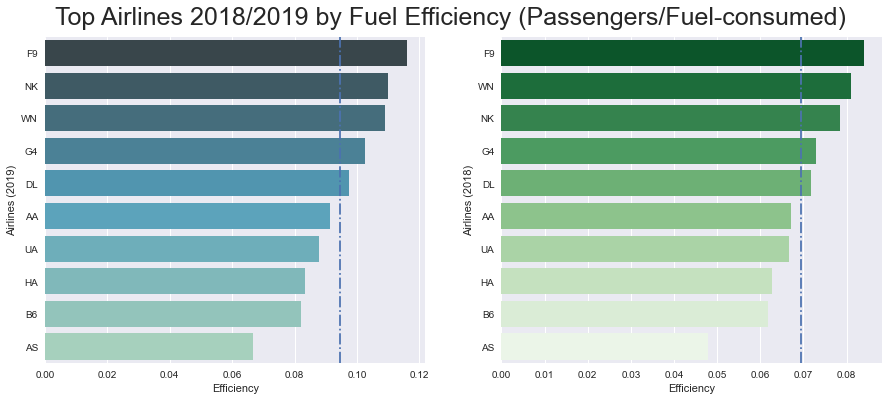

In [146]:
f, axes = plt.subplots(1, 2, figsize=(15,6))

sns.barplot(x='efficiency', y='carrier', data = df_fuel_efficiency2019.sort_values('efficiency', ascending=False), ax=axes[0], palette='GnBu_d')
sns.barplot(x='efficiency', y='carrier', data = df_fuel_efficiency2018.sort_values('efficiency', ascending=False), ax=axes[1], palette='Greens_r')

axes[0].set(ylabel='Airlines (2019)', xlabel='Efficiency')
axes[1].set(ylabel='Airlines (2018)', xlabel='Efficiency')


axes[0].axvline(df_fuel_efficiency2019['efficiency'].mean(), ls='-.', label='Mean efficiency value')
axes[1].axvline(df_fuel_efficiency2018['efficiency'].mean(), ls='-.', label='Mean efficiency value')


plt.suptitle('Top Airlines 2018/2019 by Fuel Efficiency (Passengers/Fuel-consumed)', fontsize=25,y=0.95);

In [147]:
# Frontier Among the most efficient again in terms of passengers/fuel consumed
# https://theicct.org/publications/us-domestic-airline-fuel-efficiency-ranking-2017-18

#### Fuel consumption vs

In [104]:
# domestic_flights_fuel2018, domestic_passengers2018, flights2018

In [18]:
# domestic_flights_fuel2019, domestic_passengers2019, flights2019

In [43]:
domestic_flights_fuel2019

,carrier,year,month,sdomt_gallons,tdomt_gallons,total_gallons
0,AA,2019,1,181805365.0,182280559.0,286544730.0
1,AA,2019,2,171404503.0,171809048.0,264286537.0
2,AA,2019,3,193300520.0,193844696.0,301971007.0
3,AA,2019,4,180184898.0,180567823.0,291008622.0
4,AA,2019,5,195424647.0,195785035.0,319972133.0
...,...,...,...,...,...,...
85,WN,2019,5,177347813.0,177441553.0,179914831.0
86,WN,2019,6,176316720.0,176417715.0,179131347.0
87,WN,2019,7,182539375.0,182640130.0,185099344.0
88,WN,2019,8,175218927.0,175268660.0,176971032.0


In [104]:
df2019_fuel_freight = pd.merge(domestic_passengers2019.groupby(['carrier', 'month'])['freight', 'passengers'].mean().reset_index(), domestic_flights_fuel2019, on=['carrier', 'month'])
df2019_fuel_freight = df2019_fuel_freight.loc[df2019_fuel_freight['freight'] < 120000]


df2018_fuel_freight = pd.merge(domestic_passengers2018.groupby(['carrier', 'month'])['freight', 'passengers'].mean().reset_index(), domestic_flights_fuel2018, on=['carrier', 'month'])
df2018_fuel_freight = df2018_fuel_freight.loc[df2018_fuel_freight['freight'] < 120000]

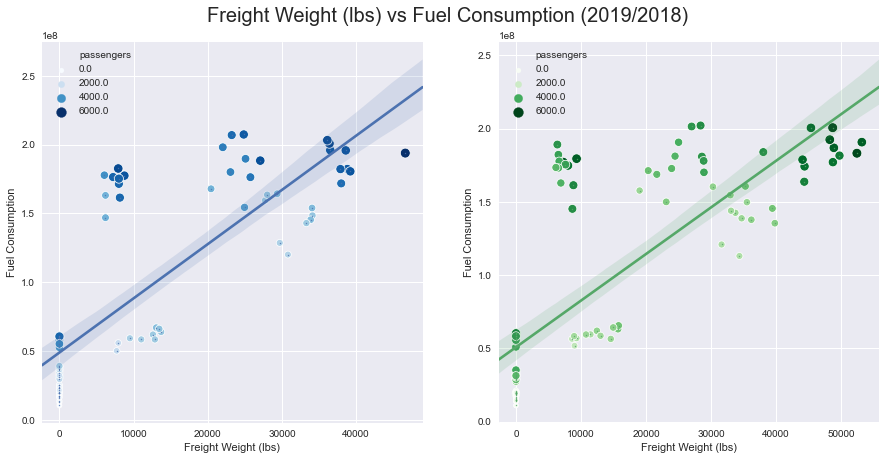

In [143]:
f, axes = plt.subplots(1, 2, figsize=(15,7))

ax1 = sns.scatterplot(x='freight', 
                      y='tdomt_gallons', 
                      size='passengers', 
                      hue='passengers', 
                      data=df2019_fuel_freight, 
                      ax=axes[0], palette='Blues')
sns.regplot(x='freight', 
            y='tdomt_gallons', 
            data=df2019_fuel_freight,
            scatter_kws={'s':2},
            ax=axes[0])
ax1.set(xlabel='Freight Weight (lbs)', ylabel='Fuel Consumption');


ax2 = sns.scatterplot(x='freight', 
                      y='tdomt_gallons',
                      size='passengers',
                      hue='passengers',
                      data=df2018_fuel_freight, 
                      ax=axes[1], palette='Greens')

sns.regplot(x='freight', 
            y='tdomt_gallons', 
            data=df2018_fuel_freight,
            scatter_kws={'s':2},
            ax=axes[1])
ax2.set(xlabel='Freight Weight (lbs)', ylabel='Fuel Consumption');

plt.suptitle('Freight Weight (lbs) vs Fuel Consumption (2019/2018)', fontsize=20,y=0.95);